### Dataset Splitting
This notebook explores a few strategies for dataset splitting.  It also serves as a demonstration of some of the splitting capabilities in useful_rdkit_utils. 

In [1]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import BulkTanimotoSimilarity
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from lgbm_wrapper import LGBMMorganCountWrapper
from sklearn.metrics import r2_score, mean_absolute_error
import itertools

#### Read the Input Data
Here are two demo dataasets.  The **biogen_logS** dataset contains the log of aqueous solubility for a diverse datasets.  The **Carbonic.smi** set is a more congeneric set of carbonic anyhydrase inhibitors. The file **biogen_logS.csv** is from [this paper](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00160)  The file **Carbonic.smi** is from [this paper](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00542). 

In [2]:
df = pd.read_csv("/Users/pwalters/software/benchmark/data/biogen_logS.csv")
#df = pd.read_csv("/Users/pwalters/modsource/python/rdkit/yamc/data/Carbonic.smi",sep=" ",names=["SMILES","Name","pIC50"])

#### Cluster the Data

In the next four cells we use functions from [useful_rdkit_utils](xxx) to define groups that will be used with **GroupKFoldShuffle** to generate training and test sets for cross validation.  Molecules in the same cluster will be placed in either the training set or the test set, but not both.  The first method **get_random_split** simply puts every molecule into its own cluster, and can be used to generate a random split. 

In [3]:
df['random_cluster'] = uru.get_random_clusters(df.SMILES)

The **get_bemis_murcko_clusters** method identifies the [Bemis-Murcko frameworks](https://pubs.acs.org/doi/10.1021/jm9602928), as defined by the [RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html), in each molecule and assigns each unique scaffold to a cluster. 

In [4]:
df['scaffold_cluster'] = uru.get_bemis_murcko_clusters(df.SMILES)

The **get_butina_clusters** method starts by using the [Butina clustering method](https://pubs.acs.org/doi/pdf/10.1021/ci9803381) in the [RDKit](https://rdkit.org/docs/source/rdkit.ML.Cluster.Butina.html) to cluster molecules.  The default distance cutoff is 0.65, which corresponds to Tanimoto similairity of 0.35. 

In [5]:
df['butina_cluster'] = uru.get_butina_clusters(df.SMILES)

The **get_umap_clusters** method follows a [paper](https://arxiv.org/abs/2406.00873) by Pedro Ballester's group.  In the paper, the Morgan fingerprints for the molecules are projected into a 2-dimensional space using the umap algorithm.  This 2-dimensional space is then clustered into 7 clusters using the AgglomerativeClustering method in scikit-learn. 

In [6]:
df['umap_cluster'] = uru.get_umap_clusters(df.SMILES, n_clusters=7)

After the operations above, the dataframe has four new columns corresponding to the clusters obtained using the methods in **useful_rdkit_utils**.

In [7]:
df

,Internal ID,Vendor ID,SMILES,CollectionName,logS,random_cluster,scaffold_cluster,butina_cluster,umap_cluster
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,0.089905,0,0,1067,6
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,0.550228,1,1,1066,6
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,1.657056,2,2,1065,1
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,1.033424,3,3,1064,1
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,0.933990,4,4,55,4
...,...,...,...,...,...,...,...,...,...
2168,Mol3493,36272797,Cc1cc(C)cc(C(=O)NCCCNc2ncccn2)c1,emolecules,1.720449,2168,1880,248,5
2169,Mol3494,48313392,CCc1noc(COc2c(C)ccnc2Cl)n1,emolecules,1.366983,2169,1881,189,0
2170,Mol3495,37024444,CC(C)(C)Cc1nnc(-c2cnc3onc(C4CCCC4)c3c2)o1,emolecules,0.600973,2170,1882,359,0
2171,Mol3496,419556,Cc1nonc1C(=O)NCCc1c[nH]c2cccc(C3(O)CCOCC3)c12,emolecules,1.786751,2171,1883,358,5


#### Comparing Dataset Sizes

Perform 5x5 cross-validation and examine the dataset sizes produced by the four splitting strategies. 

In [8]:
size_df = pd.read_csv("/Users/pwalters/software/benchmark/data/biogen_logS.csv")
size_df['mol'] = size_df.SMILES.apply(Chem.MolFromSmiles)
fpgen = rdFingerprintGenerator.GetMorganGenerator()
size_df['fp'] = size_df.mol.apply(fpgen.GetCountFingerprintAsNumPy)

split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster"]
split_dict = {"random_cluster"   : uru.get_random_clusters,
              "butina_cluster"   : uru.get_butina_clusters,
              "umap_cluster"     : uru.get_umap_clusters,
              "scaffold_cluster" : uru.get_bemis_murcko_clusters}

result_list =  []
for split in split_list:
    for i in tqdm(range(0,5),desc=split):
        cluster_list = split_dict[split](size_df.SMILES)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
            result_list.append([split,len(test)])
result_df = pd.DataFrame(result_list,columns=["split","num_test"])

random_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

butina_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

umap_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

As expected, the test set sizes are the same when **random_cluster** is used.  With **butina_cluster** and **scaffold_cluster**, we see more a bit more variability in test set sizes.  When we use **umap_cluster** there a large variability in the test size. 

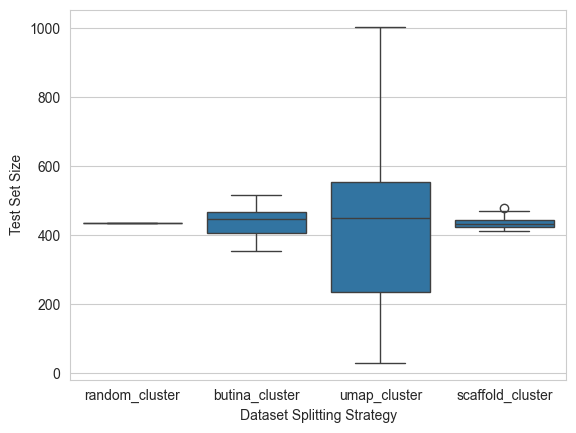

In [9]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="split",y="num_test",data=result_df)
ax.set_xlabel("Dataset Splitting Strategy")
ax.set_ylabel("Test Set Size");

The variability in test set size with **umap_cluster** can be attributed to the variation in cluster sizes.  Some of this may be due to the fact that we're only using 7 clusters.  Let's examine the impact of the number of clusters from AgglomerativeClustering on the size of the test sets. 

In [10]:
urc_result_list = []
for num_clus in tqdm(range(5,76,5)):
    for i in range(0,5):
        cluster_list = uru.get_umap_clusters(size_df.SMILES,n_clusters=num_clus)
        group_kfold_shuffle = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train, test in group_kfold_shuffle.split(np.stack(size_df.fp),size_df.logS,cluster_list):
            urc_result_list.append([num_clus,len(test)])
urc_result_df = pd.DataFrame(urc_result_list,columns=["num_clus","num_test"])   

  0%|          | 0/15 [00:00<?, ?it/s]

Looking at the plot below, the test set size seems to stabilize when we reach about 35 clusters. 

Text(0, 0.5, 'Number of Test Set Molecules')

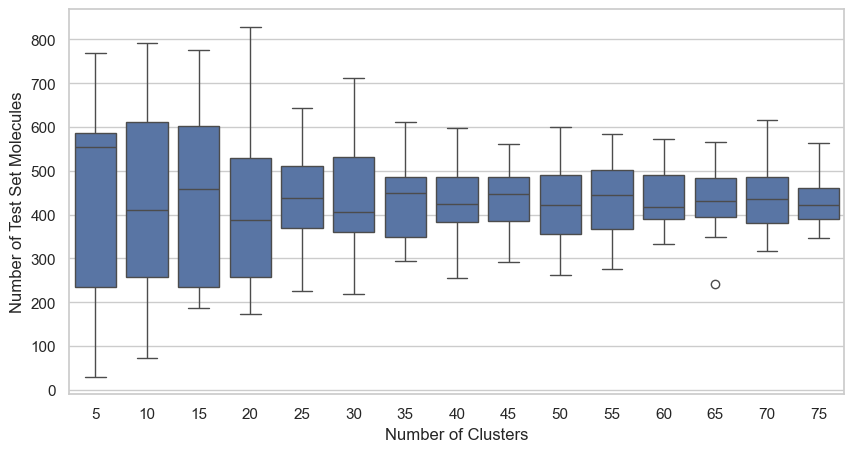

In [38]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="num_clus",y="num_test",data=urc_result_df)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Number of Test Set Molecules")

#### Make tSNE Plots to Compare the Data Splits 
We would like to generate a plot to visualize the training and test set distributions for our dataset using the different splitting methods.  To do this, we'll project the fingerprints into two dimensions using truncate stochastic neighbor embedding (tSNE).  

In [12]:
def get_tsne_coords(smiles_list):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    fp_list = [fp_gen.GetFingerprintAsNumPy(x) for x in mol_list]
    pca = PCA(n_components=50)
    pcs = pca.fit_transform(fp_list)
    tsne = TSNE(n_components=2)
    res = tsne.fit_transform(pcs)
    tsne_x = res[:,0]
    tsne_y = res[:,1]
    return tsne_x, tsne_y

Use **GroupKFoldShuffle** to split the dataset using each of methods we defined above.  Since this is simply a visual illustration, we'll only do one round of cross validation. 

In [13]:
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster"]
split_dict = {}
for split in split_list:
    kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
    for train_idx, test_idx in kf.split(df,groups=df[split]):
        split_dict[split] = [train_idx, test_idx]
        break

Any cross validation method that splits a dataset based on clusters, won't produce the same test set size every time.  Let's look at the training and test set sizes. 

In [14]:
for k,v in split_dict.items():
    print(k,len(v[0]),len(v[1]))

random_cluster 1738 435
butina_cluster 1768 405
umap_cluster 1405 768
scaffold_cluster 1735 438


Get tSNE 2D coordinates for the molecules and add them to the dataframe. 

In [15]:
tsne_x, tsne_y = get_tsne_coords(df.SMILES)
df['tsne_x'] = tsne_x
df['tsne_y'] = tsne_y

Create a new dataframe with the tSNE coordiantes. 

In [16]:
tmp_df = df[['tsne_x','tsne_y']].copy()
tmp_df.reset_index(inplace=True)

Add training and test set labels to **tmp_df** using the four splitting methods defined above. 

In [17]:
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster"]
for split in split_list:
    tmp_df[split] = "train"
    _, test_idx = split_dict[split]
    for t in test_idx:
        tmp_df[split].at[t] = "test"

Plot the chemical space of the dataset and show the training set in light blue and the test set in red.  To be honest, I don't see a large difference between the plots.  The only obvious difference is with **umap_cluster** where the test set is much more localized. 

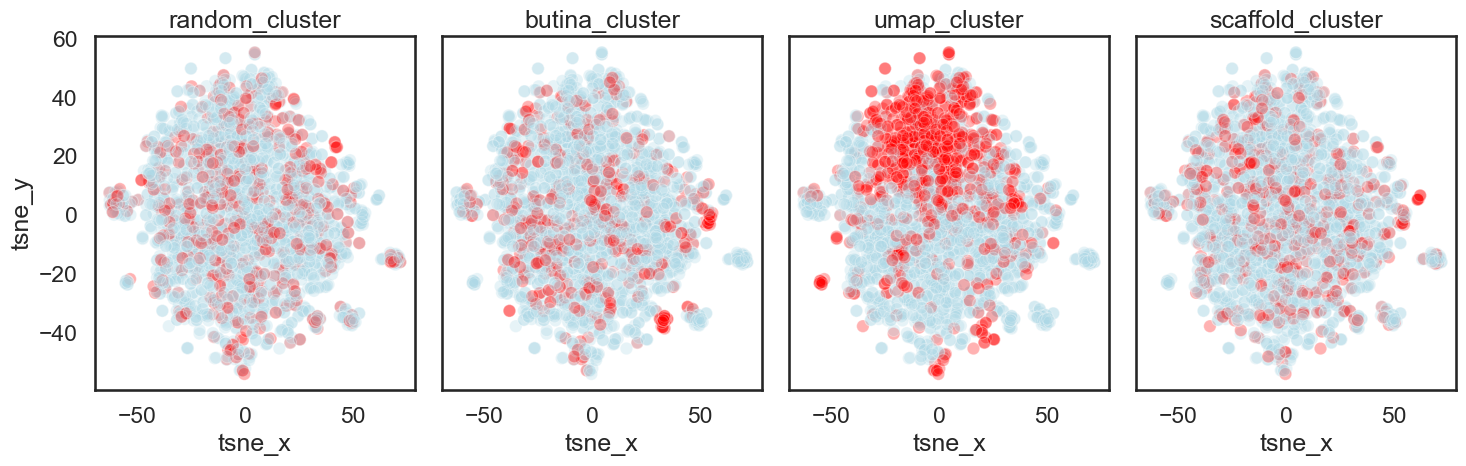

In [41]:
sns.set_style('white')
sns.set_context('talk')
figure, axes = plt.subplots(1,4, figsize=(15,5),sharey=True)
for i,split in enumerate(split_list):
    scatter_ax = sns.scatterplot(x="tsne_x",y="tsne_y",data=tmp_df,ax=axes[i],hue=split,
                                 palette={"train" : "lightblue", "test" : "red"}, hue_order=["train","test"],
                                alpha=0.3, legend=False)
    scatter_ax.set_title(split)
plt.tight_layout()

#### Calculate the Tanimoto Similarity Between the Training and Test Sets
The tSNE plots weren't very satisfying.  Instead, let's try another approach.  We will make box plots comparing the similarity to the 5 nearest training set neighbors for each test set molecule. 

In [19]:
def train_test_tanimoto(train_smiles_list, test_smiles_list, top_n=5):
    fp_gen = rdFingerprintGenerator.GetMorganGenerator()
    train_mol_list = [Chem.MolFromSmiles(x) for x in train_smiles_list]
    train_fp_list = [fp_gen.GetFingerprint(x) for x in train_mol_list]
    test_mol_list = [Chem.MolFromSmiles(x) for x in test_smiles_list]
    test_fp_list = [fp_gen.GetFingerprint(x) for x in test_mol_list]
    result_list = []
    for test_fp in test_fp_list:
        sim_list = BulkTanimotoSimilarity(test_fp, train_fp_list)
        sim_array = np.array(sim_list)
        idx = np.argpartition(np.array(sim_array),-top_n)[-top_n:]
        best_n_tanimoto = sim_array[idx]
        result_list.append(best_n_tanimoto)    
    return np.array(result_list).flatten()

In [20]:
df_list = []

for fold in tqdm(range(0,5)):
    kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
    split_list = uru.get_random_clusters(df.SMILES)
    i = 0
    test_idx_list = []
    for train_idx, test_idx in kf.split(df,groups=split_list):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()
        test['fold_cycle'] = str((fold,i))
        df_list.append(test)
        test_idx_list.append(test_idx)
        i += 1
    flat_list = list(itertools.chain(*test_idx_list))
    print(len(flat_list),len(set(flat_list)))

  0%|          | 0/5 [00:00<?, ?it/s]

2173 2173
2173 2173
2173 2173
2173 2173
2173 2173


Text(0.5, 0, 'replcate,fold')

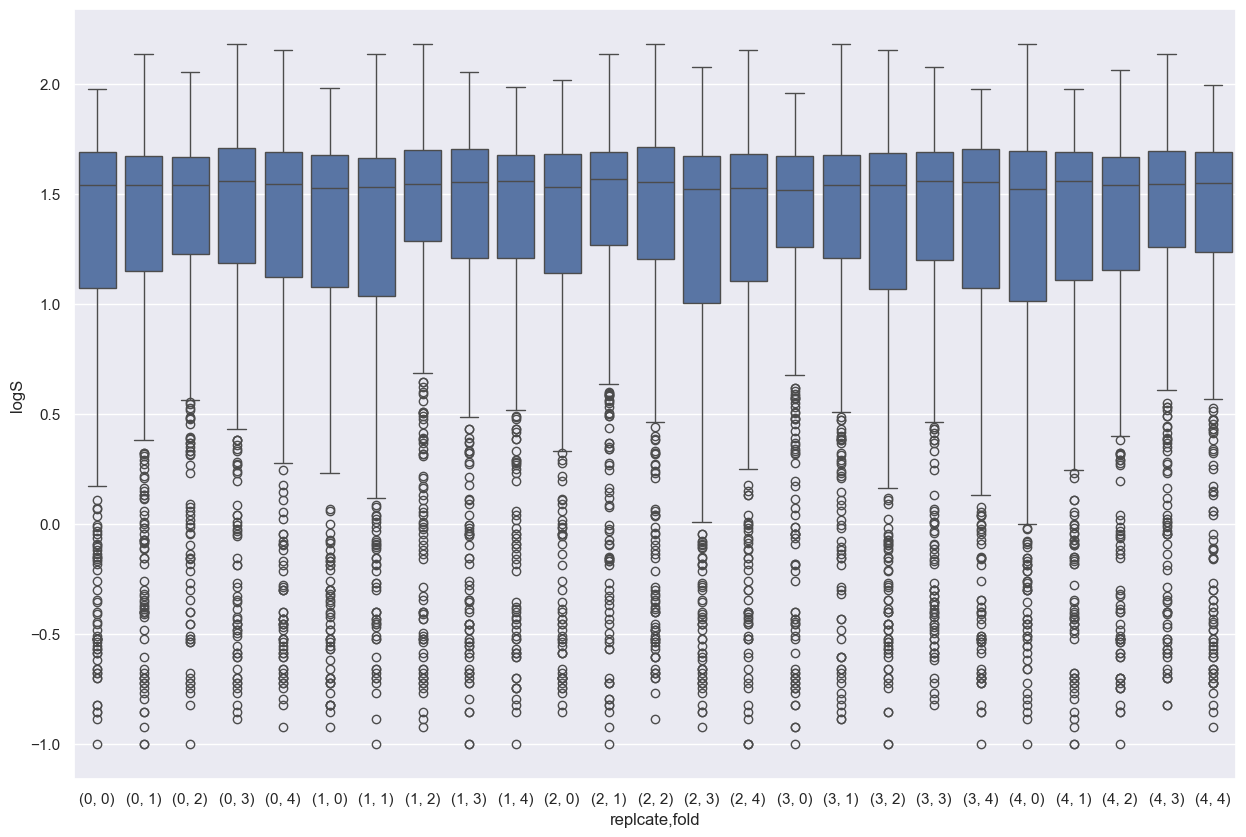

In [21]:
sns.set(rc={'figure.figsize': (15, 10)})
combo_df = pd.concat(df_list)
ax = sns.boxplot(y="logS",x="fold_cycle",data=combo_df)
ax.set_xlabel("replcate,fold")

Perform 5x5-fold cross validation calculating the Tanimoto similarity between test set molecules and training set molecules. 

In [22]:
df_list = []
split_list = ["random_cluster","butina_cluster","umap_cluster","scaffold_cluster"]
for split in split_list:
    fold = 0
    idx = 0
    for i in tqdm(range(0,5),desc=split):
        kf = uru.GroupKFoldShuffle(n_splits=5, shuffle=True)
        for train_idx, test_idx in kf.split(df,groups=df[split]):
            train = df.iloc[train_idx]
            test = df.iloc[test_idx] 
            sim_vals = train_test_tanimoto(train.SMILES, test.SMILES)
            idx = np.arange(0,len(sim_vals)) + fold*len(sim_vals)
            sim_df = pd.DataFrame({"sim" : sim_vals, "fold" : fold, "split" : split, "idx" : idx })
            fold += 1
            df_list.append(sim_df)

random_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

butina_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

umap_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold_cluster:   0%|          | 0/5 [00:00<?, ?it/s]

Plot distributions of Tamimoto similairty for the 5 nearest neighbors for each test set molecule.  Only plot the first 10 cross-validation folds so the plot doesn't get overly crowded. 

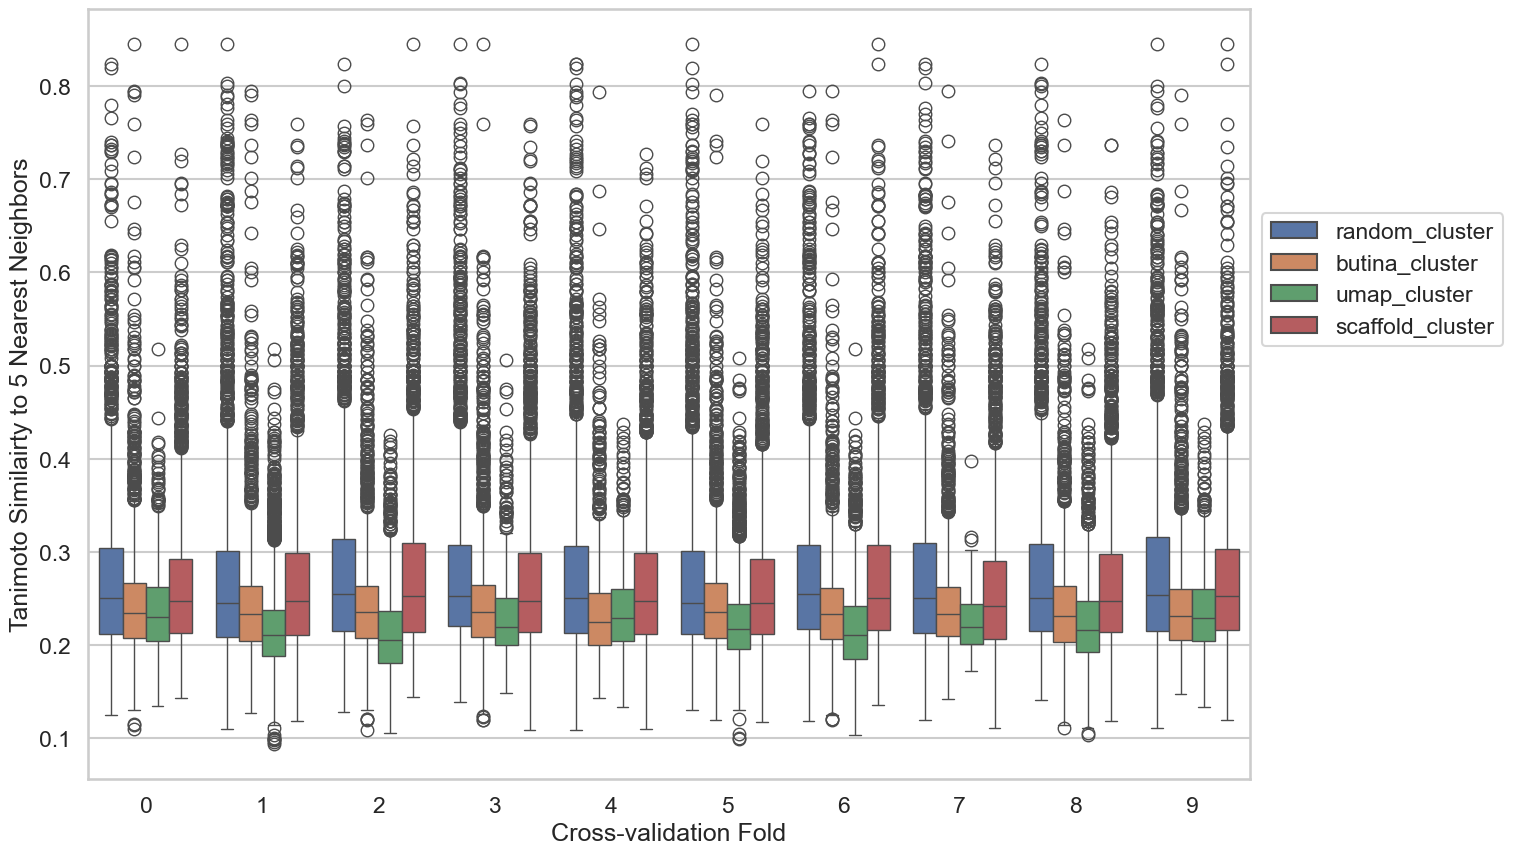

In [39]:
combo_df = pd.concat(df_list)
sns.set(rc={'figure.figsize' : (15,10)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.boxplot(data=combo_df.query("fold < 10"),x="fold",y="sim",hue="split")
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
ax.set_xlabel("Cross-validation Fold")
ax.set_ylabel("Tanimoto Similairty to 5 Nearest Neighbors");

Make boxplots of Tanimoto similarity of each test set molecule to its 5 nearest neighbors.  This is simply the plot above where all cross-validation fold are pooled. 

<Axes: xlabel='split', ylabel='sim'>

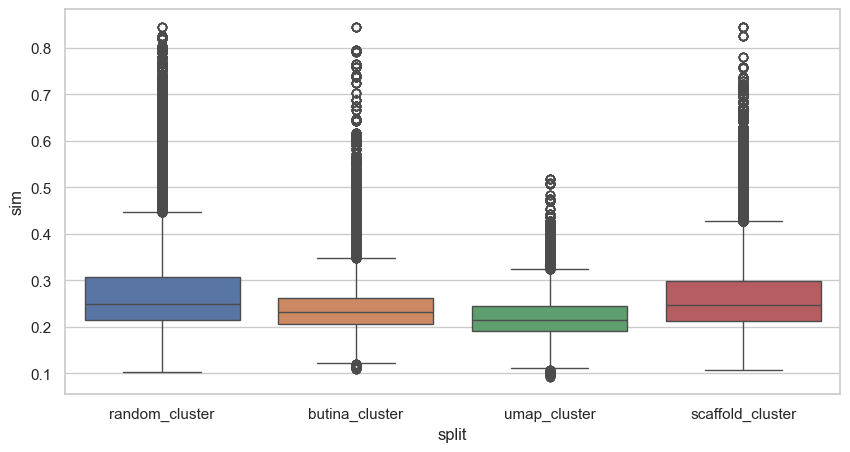

In [24]:
sns.set(rc={'figure.figsize' : (10,5)})
sns.set_style('whitegrid')
sns.boxplot(data=combo_df, x="split", y="sim", hue="split")

Use the Tukey Honestly Significant Difference (HSD) test to determine whether the differences between Tanimoto similairty distributions are signficant. 

In [43]:
tukey_res = pairwise_tukeyhsd(combo_df.sim, combo_df.split)

In [44]:
print(tukey_res)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------------
  butina_cluster   random_cluster   0.0369   0.0  0.0357  0.0381   True
  butina_cluster scaffold_cluster   0.0273   0.0  0.0261  0.0285   True
  butina_cluster     umap_cluster  -0.0218   0.0 -0.0231 -0.0206   True
  random_cluster scaffold_cluster  -0.0096   0.0 -0.0108 -0.0083   True
  random_cluster     umap_cluster  -0.0587   0.0   -0.06 -0.0575   True
scaffold_cluster     umap_cluster  -0.0491   0.0 -0.0504 -0.0479   True
-----------------------------------------------------------------------


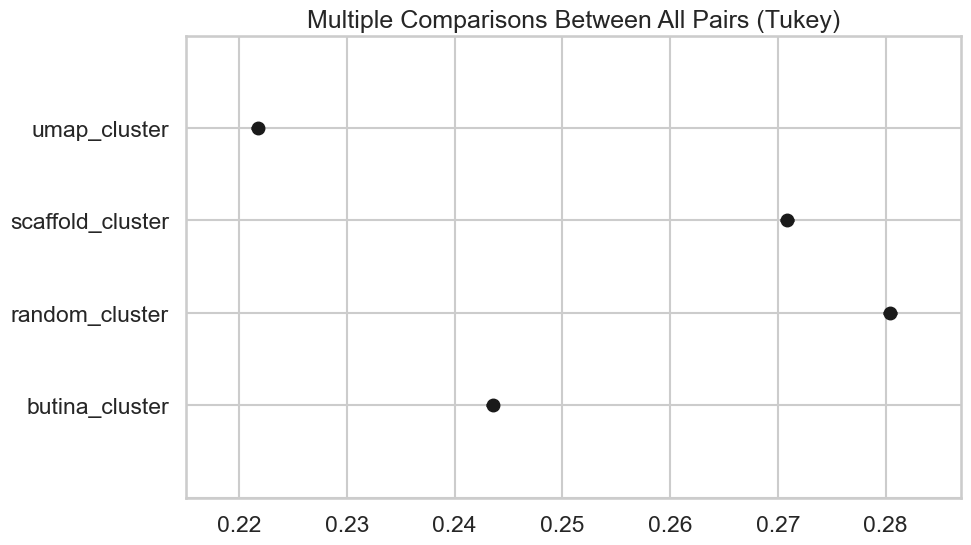

In [45]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous()

#### Examine the Impact of Dataset Splitting on ML Model Performance 
We've seen how the different splitting methods affect the similairty between the training and test sets.  Now let's see how the same splits impact model performance.  To do this, we will use the **cross_validate** function in useful_rdkit_utils.  To use the function we pass the following arguments. 
* An input dataframe, which must contain a SMILES column
* A list of tuples containing a model name and and instance of a wrapper class that runs a model. The wrapper class must support an **evaluate** function which takes dataframes containing training and test sets as input and returns a list of predictions for the test set.
* The name of the **y** variable in the dataframe
* A list of tuples containing a name and a function to group the data.  These groups will be passed to an instance of **GroupKFoldShuffle**
* The number of outer cross-validation folds
* The number of inner cross-validation folds

While this may sound complicated, it's actually simple.  The code block below defines the model list, the group list, and the y column. We are comparing 
* one model - LightGBM
* four splitting methods - butina, random, scaffold, and umap
  
The **y** column in the dataset is **logS**.  That's it. 

In [28]:
model_list = [("lgbm_morgan", LGBMMorganCountWrapper)]
group_list = [("butina", uru.get_butina_clusters), ("random", uru.get_random_clusters),
              ("scaffold", uru.get_bemis_murcko_clusters), ("umap", uru.get_umap_clusters)]
y = "logS"

With the definitions above, call **cross_validate**, which returns a dataframe with the training and test sets for each fold, as well as the predicted values. 

In [29]:
result_df = uru.cross_validate(df, model_list, y, group_list, 5, 5)
outfile_name = "biogen_logS_results.csv"
result_df.to_csv(outfile_name, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

random:   0%|          | 0/5 [00:00<?, ?it/s]

scaffold:   0%|          | 0/5 [00:00<?, ?it/s]

umap:   0%|          | 0/5 [00:00<?, ?it/s]

Now, we'll calculate some statistics on the dataset.  To do this, we only need the data from the test set. 

In [30]:
test_df = result_df.query("dset == 'test'")

Collect the data from the cross-validation folds and calculate $R^2$ for each fold.  This will give us a distribution of $R^2$ values for each splitting method. 

In [31]:
out_list = []
for k,v in test_df.groupby(["group","fold"]):
    group, fold = k
    r2 = r2_score(v.logS,v.lgbm_morgan)
    out_list.append([group, fold, r2])
out_df = pd.DataFrame(out_list,columns=["split","fold","r2"])

In [32]:
out_df

,split,fold,r2
0,butina,0,0.228193
1,butina,1,0.252403
2,butina,2,0.301593
3,butina,3,0.278102
4,butina,4,0.286517
...,...,...,...
95,umap,20,0.064307
96,umap,21,0.249207
97,umap,22,0.097348
98,umap,23,0.192562


Plot a boxplot showing the $R^2$ distributions for each splitting method. 

Text(0.5, 0, 'Split')

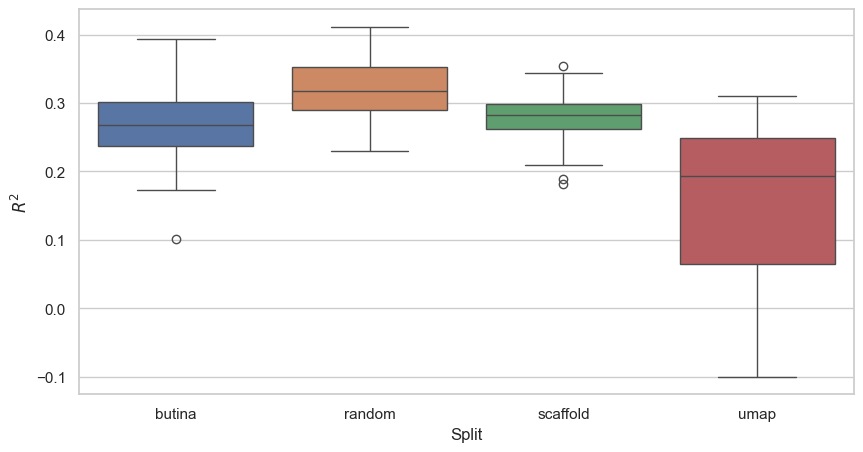

In [33]:
sns.set_style('whitegrid')
ax = sns.boxplot(x="split",y="r2",hue="split",data=out_df)
ax.set_ylabel("$R^2$")
ax.set_xlabel("Split")

From the plot above, it's clear that the **umap** splits are the most challenging for the model.  The $R^2$ distributions for the butina, random, and scaffold splits appear similar.  We can use the Tukey HSD test to determine whether statistically significant differences exist between the splitting methods.  The table **tukey_res** table below shows the following. 
* **group1** - the first split being compared
* **group2** - the second split being compared
* **meandiff** - the mean difference between the two splitting methods
* **p-adj** - the p-value for the difference between distributions, corrected for multiple comparisons
* **lower** - the lower bound of the confidence interval
* **upper** - the upper bound of thhe confidence interval
* **reject** - can we reject the null hypothesis that the means of the distributions are the same

In [46]:
tukey_res = pairwise_tukeyhsd(out_df.r2, out_df.split)

In [47]:
print(tukey_res)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  butina   random   0.0564 0.0674 -0.0027  0.1155  False
  butina scaffold   0.0153 0.9056 -0.0438  0.0744  False
  butina     umap  -0.1203    0.0 -0.1795 -0.0612   True
  random scaffold  -0.0411 0.2722 -0.1002  0.0181  False
  random     umap  -0.1767    0.0 -0.2359 -0.1176   True
scaffold     umap  -0.1357    0.0 -0.1948 -0.0765   True
--------------------------------------------------------


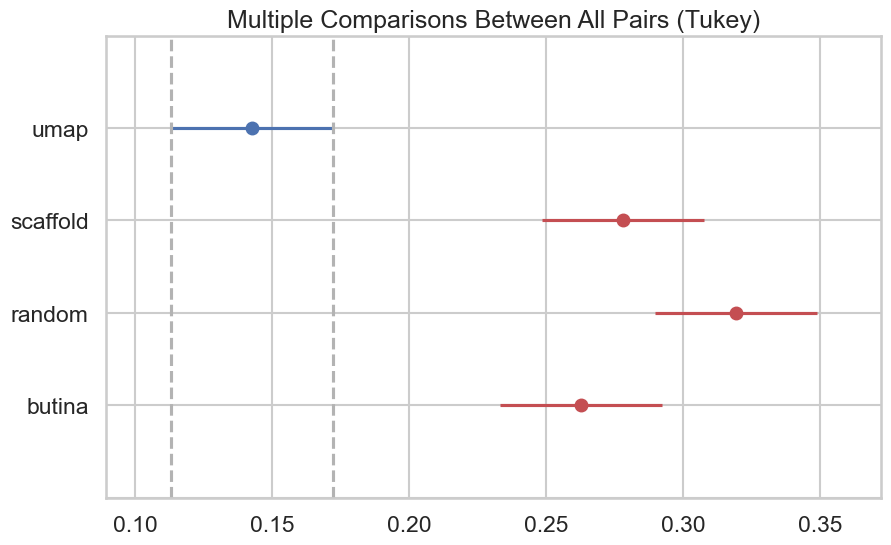

In [48]:
sns.set_style('whitegrid')
sns.set_context('talk')
_ = tukey_res.plot_simultaneous(comparison_name="umap")